# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import math
import sklearn
import seaborn as sns
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers, Sequential
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Import Dataset

In [ ]:
Binance_data = pd.read_parquet('1INCH-BTC.parquet')
Binance_data.head()

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
open_time,,,,,,,,,
2020-12-25 05:00:00,0.000009,0.000168,0.000009,0.000106,121635.101562,13.708220,561,39139.000000,4.596730
2020-12-25 05:01:00,0.000106,0.000113,0.000091,0.000101,68514.296875,6.990613,523,10134.000000,1.031620
2020-12-25 05:02:00,0.000102,0.000118,0.000101,0.000115,58331.500000,6.432216,414,7388.600098,0.801500
2020-12-25 05:03:00,0.000114,0.000140,0.000108,0.000112,81144.398438,9.602539,553,40707.101562,5.047240
2020-12-25 05:04:00,0.000112,0.000114,0.000107,0.000108,33466.800781,3.697582,309,11160.799805,1.232953


# Exploratory Data Analysis

<Axes: >

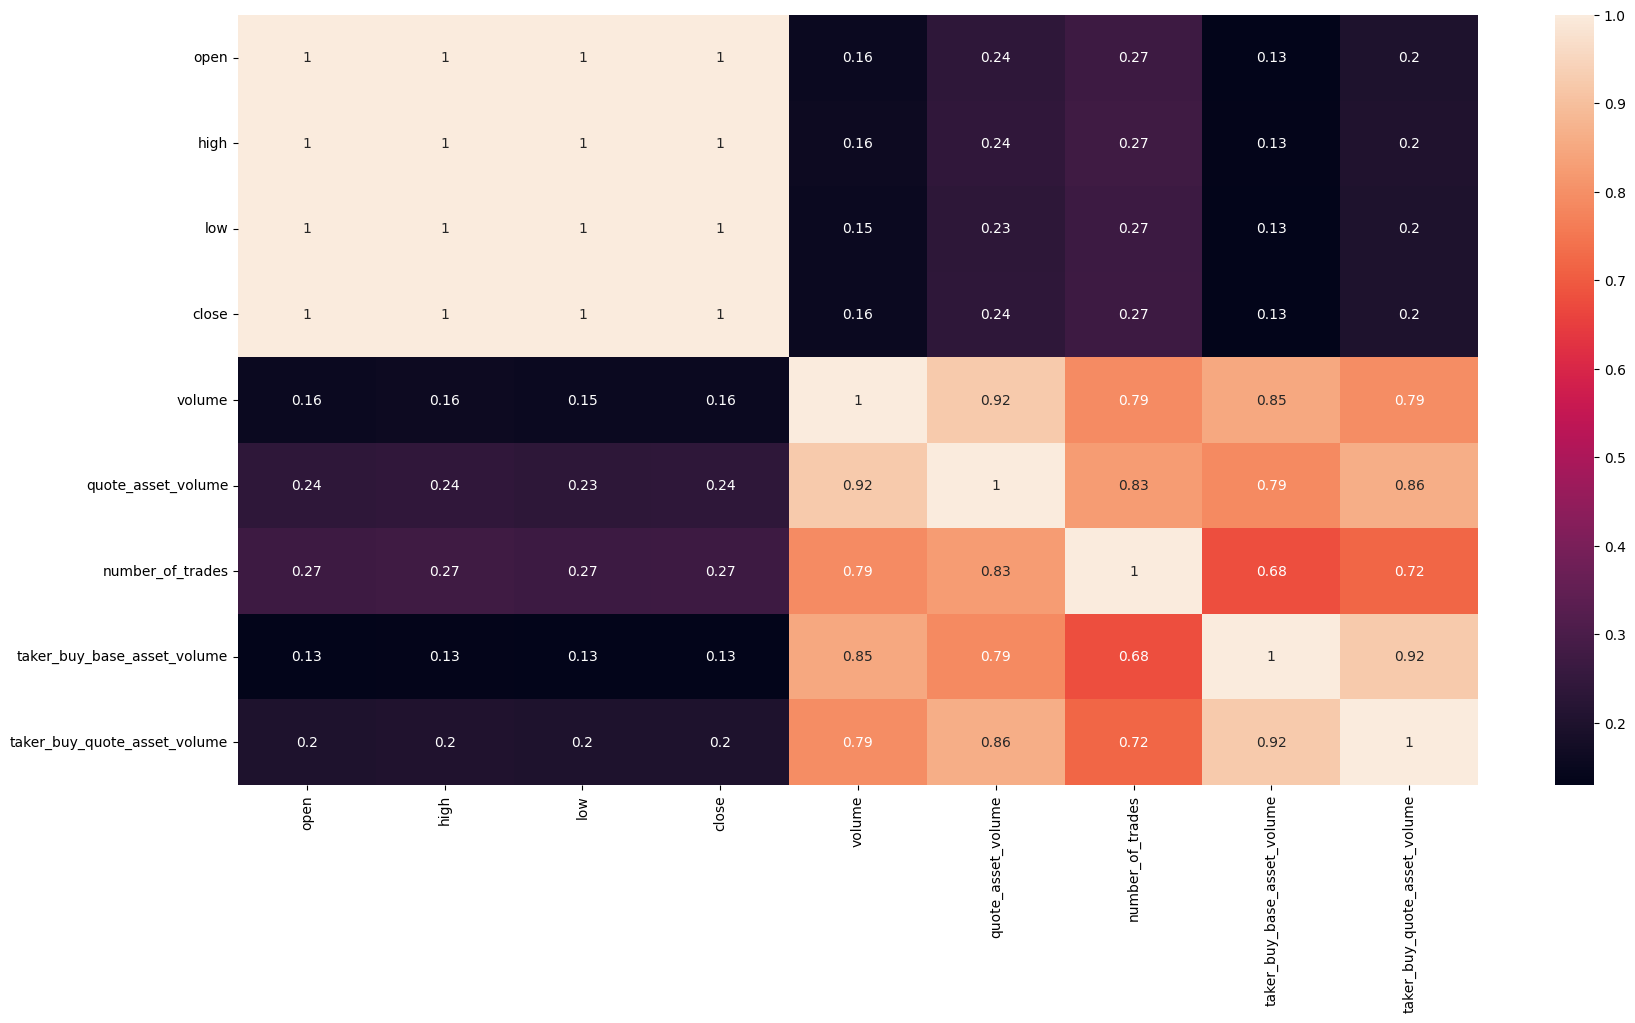

In [ ]:

plt.figure(figsize=(20, 10))
sns.heatmap(Binance_data.corr(), annot=True)

In [ ]:
Binance=Binance_data.drop(['quote_asset_volume','number_of_trades','taker_buy_base_asset_volume',
                   'taker_buy_quote_asset_volume'], axis=1)

In [ ]:
Binance.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 995183 entries, 2020-12-25 05:00:00 to 2022-11-16 23:59:00
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    995183 non-null  float32
 1   high    995183 non-null  float32
 2   low     995183 non-null  float32
 3   close   995183 non-null  float32
 4   volume  995183 non-null  float32
dtypes: float32(5)
memory usage: 26.6 MB


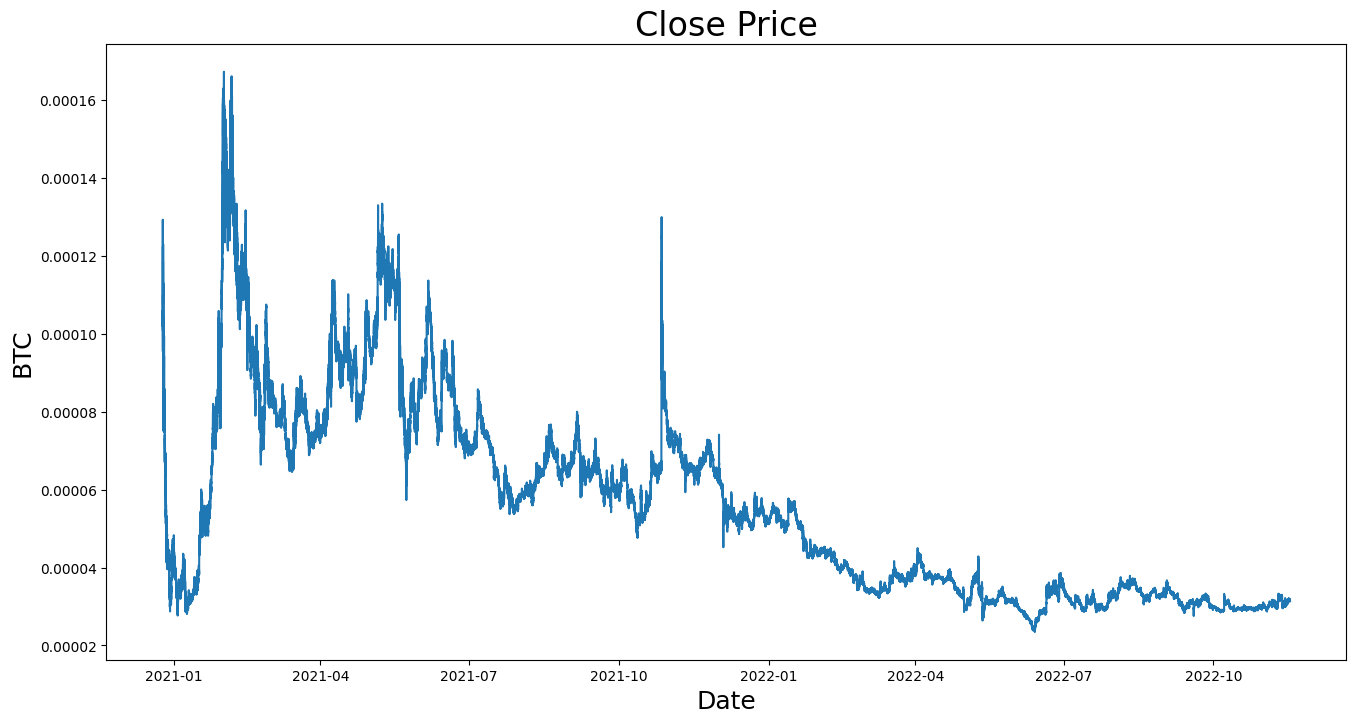

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Close Price', fontsize=24)
plt.plot(Binance_data['close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('BTC', fontsize=18)
plt.show()

# Splitting data into Training, Test and Validation set

In [ ]:
"""
from sklearn.model_selection import train_test_split
Dataset_train, Dataset_test = train_test_split(Binance, test_size=0.2, random_state=42)
#val_set=Dataset_val.iloc[:,1:2].values
"""

'\nfrom sklearn.model_selection import train_test_split\nDataset_train, Dataset_test = train_test_split(Binance, test_size=0.2, random_state=42)\n#val_set=Dataset_val.iloc[:,1:2].values\n'

In [ ]:
data = Binance.filter(['close'])
#data = Binance.iloc[:,1:2].values
#Binance_training=Dataset_train.iloc[:,1:2].values
dataset = data.values
training_data_len = math.ceil(len(data) * .8)
training_data_len

796147

In [ ]:
#Dataset_train, Dataset_val = train_test_split(Dataset_train, test_size=0.2, random_state=42)

# Data Preparation

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler(feature_range=(0,1))
Binance_training_scaled=sc.fit_transform(data)

In [ ]:
training_set = Binance_training_scaled[0:training_data_len, :]
x_train = []
y_train = []
#x_val=[]
#y_val=[]

In [ ]:
for i in range(100, 796147):
    x_train.append(Binance_training_scaled[i-100:i, 0])
    y_train.append(Binance_training_scaled[i, 0])
x_train,y_train=np.array(x_train), np.array(y_train)

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1], 1))

In [ ]:
#x_train.shape

# Building LSTM Network

In [ ]:
from tensorflow.keras import models, layers, Sequential

In [ ]:
Reg = Sequential()
Reg.add(layers.LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
Reg.add(layers.Dropout(0.2))
Reg.add(layers.LSTM(50, return_sequences=True))
Reg.add(layers.Dropout(0.2))
Reg.add(layers.LSTM(50, return_sequences=True))
Reg.add(layers.Dropout(0.2))
Reg.add(layers.LSTM(50))
Reg.add(layers.Dropout(0.2))
Reg.add(layers.Dense(1))

# Training Model

In [ ]:
Reg.compile(optimizer='adam',loss='mean_squared_error')

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
Reg.fit(x_train,y_train, epochs=4, batch_size=32)

Epoch 1/4
24877/24877 [==============================] - 452s 18ms/step - loss: 3.0026e-04
Epoch 2/4
24877/24877 [==============================] - 435s 17ms/step - loss: 2.1869e-04
Epoch 3/4
24877/24877 [==============================] - 433s 17ms/step - loss: 2.0504e-04
Epoch 4/4
24877/24877 [==============================] - 436s 18ms/step - loss: 1.9161e-04


In [ ]:
test_data = Binance_training_scaled[training_data_len - 100 : , :]

In [ ]:
X_test = []
y_test = dataset[training_data_len : , :]
for i in range(100, len(test_data)):
  X_test.append(test_data[i-100 : i, 0])

In [ ]:
X_test = np.array(X_test)

In [ ]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
X_test.shape

(199036, 100, 1)

In [ ]:
predictions_2 = Reg.predict(X_test)
predictions_2 = sc.inverse_transform(predictions_2)
len(predictions_2)

6220/6220 [==============================] - 46s 7ms/step


199036

In [ ]:
rmse_1 = np.sqrt(np.mean(predictions_2 - y_test)**2)
rmse_1

2.0478435658333183e-07

In [ ]:
train = data[:training_data_len]
valid_2 = data[training_data_len:]
valid_2['Predictions'] = predictions_2

<ipython-input-35-37d95d5410cb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_2['Predictions'] = predictions_2


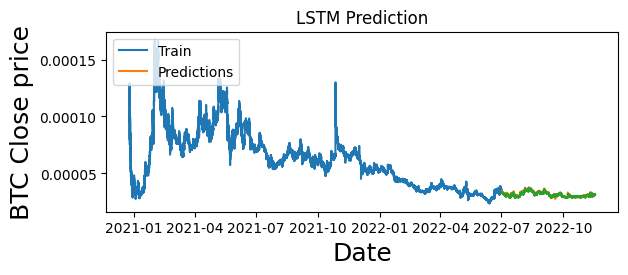

In [ ]:
plt.subplot(2, 1, 2)
plt.title('LSTM Prediction')
plt.xlabel('Date', fontsize=18)
plt.ylabel('BTC Close price', fontsize=18)
plt.plot(train['close'])
plt.plot(valid_2[['close', 'Predictions']])

plt.legend(['Train', 'Predictions'], loc='upper left')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=1,
                    wspace=0.4,
                    hspace=0.4)
plt.show()

In [ ]:
GRU = Sequential()
GRU.add(layers.GRU(50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
GRU.add(layers.Dropout(0.2))
GRU.add(layers.GRU(50, return_sequences=True))
GRU.add(layers.Dropout(0.2))
GRU.add(layers.GRU(50, return_sequences=True))
GRU.add(layers.Dropout(0.2))
GRU.add(layers.GRU(50))
GRU.add(layers.Dropout(0.2))
GRU.add(layers.Dense(1))

In [ ]:
GRU.compile(optimizer='adam', loss='mse')

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
history=GRU.fit(x_train,y_train, epochs=4, batch_size=32)

Epoch 1/4
24877/24877 [==============================] - 430s 17ms/step - loss: 2.9287e-04
Epoch 2/4
24877/24877 [==============================] - 419s 17ms/step - loss: 2.0771e-04
Epoch 3/4
24877/24877 [==============================] - 418s 17ms/step - loss: 1.9975e-04
Epoch 4/4
24877/24877 [==============================] - 422s 17ms/step - loss: 1.9616e-04


In [ ]:
predictions_1 = GRU.predict(X_test)
predictions_1 = sc.inverse_transform(predictions_1)
len(predictions_1)

6220/6220 [==============================] - 47s 7ms/step


199036

In [ ]:
rmse_2 = np.sqrt(np.mean(predictions_1 - y_test)**2)
rmse_2

2.449316127695056e-07

In [ ]:
train = data[:training_data_len]
valid_1 = data[training_data_len:]
valid_1['Predictions'] = predictions_1

<ipython-input-43-e1f87c6458c7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_1['Predictions'] = predictions_1


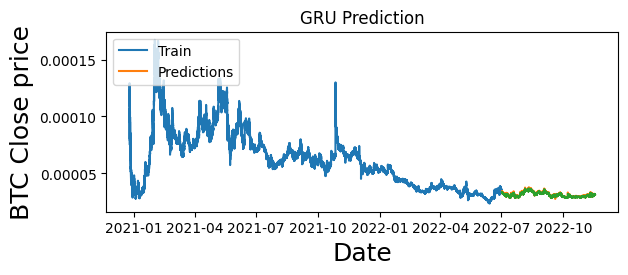

In [ ]:
plt.subplot(2, 1, 2)
plt.title('GRU Prediction')
plt.xlabel('Date', fontsize=18)
plt.ylabel('BTC Close price', fontsize=18)
plt.plot(train['close'])
plt.plot(valid_1[['close', 'Predictions']])

plt.legend(['Train', 'Predictions'], loc='upper left')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=1,
                    wspace=0.4,
                    hspace=0.4)
plt.show()

In [ ]:
last_100_days = data[-100:].values
last_100_days_scaled = sc.fit_transform(last_100_days)
new_X_test = []
new_X_test.append(last_100_days_scaled)
new_X_test = np.array(new_X_test)
new_X_test = np.reshape(new_X_test, (new_X_test.shape[0], new_X_test.shape[1], 1))
pred_price = Reg.predict(new_X_test)
pred_price = sc.inverse_transform(pred_price)
print(pred_price)

1/1 [==============================] - 0s 29ms/step
[[0.01543288]]


In [ ]:
last_100_days = data[-100:].values
last_100_days_scaled = sc.fit_transform(last_100_days)
new_X_test = []
new_X_test.append(last_100_days_scaled)
new_X_test = np.array(new_X_test)
new_X_test = np.reshape(new_X_test, (new_X_test.shape[0], new_X_test.shape[1], 1))
pred_price_2 = GRU.predict(new_X_test)
pred_price_2 = sc.inverse_transform(pred_price_2)
print(pred_price_2)

1/1 [==============================] - 0s 39ms/step
[[0.0013844]]
